In [1]:
from __future__ import print_function, division
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import concurrent.futures
import time
import random
import argparse
from tqdm.notebook import tqdm

ImportError: cannot import name 'Coordinates' from 'xarray' (/Users/rsparks3/anaconda3/lib/python3.10/site-packages/xarray/__init__.py)

In [82]:
substations_df = pd.read_csv("output/Substation.csv")
buses_df = pd.read_csv("output/Bus.csv")
gen_df = pd.read_csv("output/Gen.csv")
lines_df = pd.read_csv("output/Line.csv")
loads_df = pd.read_csv("output/Load.csv")
transformers_df = pd.read_csv("output/Transformer.csv")

In [83]:
mva_base = 100

#time it
start = time.perf_counter()

def import_network_from_csvs():
    global substations_df
    global buses_df
    global gen_df
    global lines_df
    global loads_df
    global transformers_df
    global line_limits
    
    substations_df = pd.read_csv("output/Substation.csv")
    buses_df = pd.read_csv("output/Bus.csv")
    gen_df = pd.read_csv("output/Gen.csv")
    lines_df = pd.read_csv("output/Line.csv")
    loads_df = pd.read_csv("output/Load.csv")
    transformers_df = pd.read_csv("output/Transformer.csv")
    
    network = pypsa.Network()

    line_limits = {}

    for idx, row in tqdm(buses_df.iterrows(), desc="Adding busses", total=len(buses_df)):
        name = row['BusName']
        subnum = row['SubNum']
        voltage = row['BusNomVolt']
        lat = substations_df[substations_df['SubNum']==subnum]['Latitude'].values
        long = substations_df[substations_df['SubNum']==subnum]['Longitude'].values
        #lat = substations_df.loc[subnum-1]['Latitude']
        #long = substations_df.loc[subnum-1]['Longitude']
        network.add("Bus", name, x=long, y=lat, v_nom=voltage)

    for idx, row in tqdm(lines_df.iterrows(), desc="Adding lines", total=len(lines_df)):
        bus1num = row['BusNum']
        bus1name = buses_df.loc[buses_df['BusNum']==bus1num]['BusName'].item()
        bus2num = row['BusNum:1']
        bus2name = buses_df.loc[buses_df['BusNum']==bus2num]['BusName'].item()
        voltage = buses_df.loc[buses_df['BusNum']==bus1num]['BusNomVolt'].item()
        r = row['LineR'] * ((voltage**2)/mva_base)   ## r = per unit resistance * impedance base
        x = row['LineX'] * ((voltage**2)/mva_base)   ## x = per unit reactance * impedance base
        mva_limit = row['LineAMVA']
        name = "Line-{}-{}".format(bus1num, bus2num)
        while name in network.lines.index:
            name="{}-2".format(name)
        #print(name)
        line_limits[name] = mva_limit
        network.add("Line", name, bus0=bus1name, bus1=bus2name, x=x, r=r)

    for idx, row in tqdm(loads_df.iterrows(), desc="Adding loads", total=len(loads_df)):
        busnum = row['BusNum']
        p = row['LoadSMW']
        q = row['LoadSMVR']
        name = "{}-Load".format(busnum)
        while name in network.loads.index.values:
            name += "-1"
        #print(name)
        network.add("Load", name, bus=buses_df.loc[buses_df['BusNum']==busnum]['BusName'].item(), p_set=p, q_set=q)

    for idx, row in tqdm(gen_df.iterrows(), desc="Adding gen", total=len(gen_df)):
        busnum = row['BusNum']
        busname = buses_df.loc[buses_df['BusNum']==busnum]['BusName'].item()
        genid = row['GenID']
        name = "{}-{}".format(busname, genid)
        v_pu = row['GenVoltSet']
        p = row['GenMWSetPoint']
        status = row['GenStatus']

        if status == "Closed":        
            network.buses.at[busname,'v_mag_pu_set'] = v_pu
            network.add("Generator", name, bus=busname, p_set=p, control="Slack")
            #print(name)

    for idx, row in tqdm(transformers_df.iterrows(), desc="Adding transformers", total=len(transformers_df)):
        bus1num = row['BusNum']
        bus1name = buses_df.loc[buses_df['BusNum']==bus1num]['BusName'].item()
        bus2num = row['BusNum:1']
        bus2name = buses_df.loc[buses_df['BusNum']==bus2num]['BusName'].item()
        r = row['LineR:1']  # PyPSA expects PU for these! :)
        x = row['LineX:1']
        s_nom = row['XFMVABase']
        name = "{}-{}-txfmr".format(bus1name, bus2name)
        while name in network.transformers.index:
            name="{}-2".format(name)
        network.add("Transformer", name, bus0=bus1name, bus1=bus2name, x=x, r=r, s_nom=s_nom)
    
    return(network);

network = import_network_from_csvs()

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/components.py:315: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/components.py:315: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/components.py:315: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/components.py:315: F

Adding busses:   0%|          | 0/70000 [00:00<?, ?it/s]

Adding lines:   0%|          | 0/77652 [00:00<?, ?it/s]

Adding loads:   0%|          | 0/38181 [00:00<?, ?it/s]

/var/folders/dk/3hl3mmls0gs66kjcnlw3cxs80000gq/T/ipykernel_88451/638652503.py:57: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



Adding gen:   0%|          | 0/10390 [00:00<?, ?it/s]

Adding transformers:   0%|          | 0/10555 [00:00<?, ?it/s]

In [84]:
network.lpf()

INFO:pypsa.pf:Performing linear load-flow on AC sub-network SubNetwork 0 for snapshot(s) Index(['now'], dtype='object', name='snapshot')
/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/pf.py:1513: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/pypsa/pf.py:1513: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:276: MatrixRankWarning:

Matrix is exactly singular



In [87]:
import geopy.distance
syntheticlengthlist = []

for linename, row in network.lines.iterrows():
    #print(row['bus0'])
    bus0x = network.buses.loc[row['bus0']]['x']
    bus0y = network.buses.loc[row['bus0']]['y']
    bus1x = network.buses.loc[row['bus1']]['x']
    bus1y = network.buses.loc[row['bus1']]['y']
    
    coords1=(bus0y,bus0x)
    coords2=(bus1y,bus1x)
    
    dist = geopy.distance.geodesic(coords1,coords2).km
    syntheticlengthlist.append(dist)

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning:

All-NaN slice encountered

/Users/rsparks3/anaconda3/envs/cimd/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning:

All-NaN slice encountered



ValueError: autodetected range of [nan, nan] is not finite

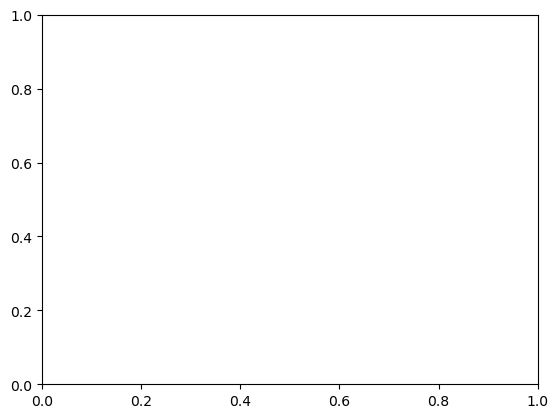

In [89]:
syntheticlineloading = []
for line in line_limits:
    limit = line_limits[line]
    load = abs(network.lines_t['p0'].T.loc[line]['now'])
    percent = load/limit * 100
    syntheticlineloading.append(percent)
plt.hist(syntheticlineloading, log=True, color=(0.298, 0, 0.729), edgecolor='black', weights=syntheticlengthlist)
plt.xlabel('Line Loading (%)')
plt.ylabel('Length of lines')
plt.title('Eastern Interconnect 70k bus case (Birchfield)')
plt.ylim([1,1000])